In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import keras

2025-07-19 08:19:42.345344: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-19 08:19:42.371740: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-19 08:19:42.371774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-19 08:19:42.372583: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-19 08:19:42.377370: I tensorflow/core/platform/cpu_feature_guar

In [2]:
os.listdir()

['dataset_generation.ipynb',
 'dots_prediction - Copy.ipynb',
 'dots_prediction.ipynb',
 'gif_outputs',
 'gif_outputs_3balls',
 'gif_toshow',
 'logs',
 'ltc_prediction.gif',
 'LTC_wiring_visualization.ipynb',
 'moving_balls_dataset.npy',
 'moving_balls_dataset_3balls.npy',
 'pred_demo',
 'Research_Note_07_05_2025.pdf']

In [3]:
dataset = np.load("moving_balls_dataset.npy")
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)
print(f"type: {type(dataset)}")
print(f"shape: {dataset.shape}")

type: <class 'numpy.ndarray'>
shape: (2000, 20, 64, 64, 1)


In [4]:
# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

In [5]:
train_dataset.shape

(1800, 20, 64, 64, 1)

In [6]:
# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (1800, 19, 64, 64, 1), (1800, 19, 64, 64, 1)
Validation Dataset Shapes: (200, 19, 64, 64, 1), (200, 19, 64, 64, 1)


Displaying frames for example 193.


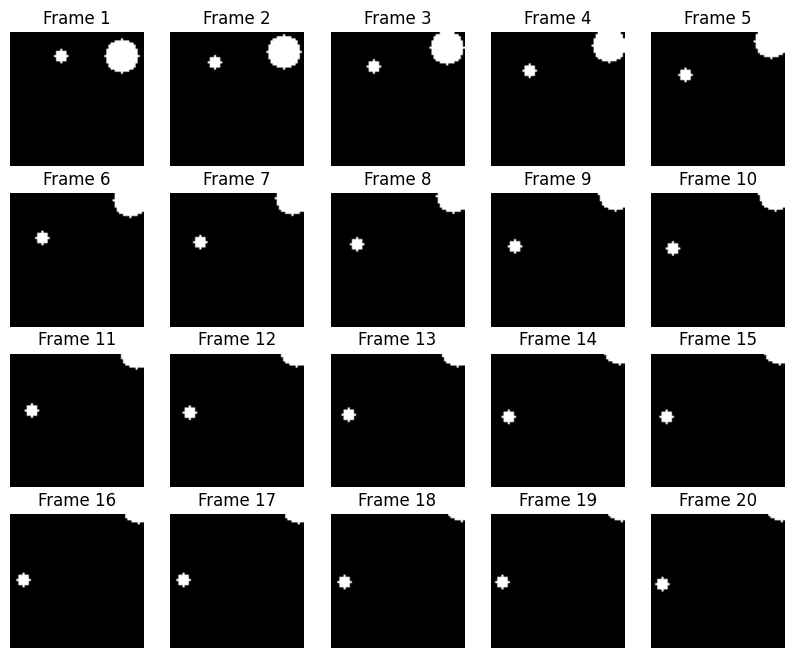

In [7]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [8]:
data_choice

193

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
from matplotlib.animation import PillowWriter
from IPython.display import Image, display


def frames2gif(output_dir="gif_toshow",gif_name= f"sample_{data_choice}.gif",ds_demo=train_dataset[data_choice]):

    # 加载数据
    os.makedirs(output_dir, exist_ok=True)

    # 指定想保存的样本索引（可改为 range(len(dataset)) 保存全部）

    frames = ds_demo
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(frames[0], cmap="gray", animated=True)
    ax.axis("off")
    ax.set_title(f"sample")

    def update(frame_idx):
        im.set_array(frames[frame_idx])
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=100, blit=True)

    # ✅ 使用 PillowWriter 保存为 GIF
    gif_path = os.path.join(output_dir, gif_name)
    writer = PillowWriter(fps=10)
    ani.save(gif_path, writer=writer)
    plt.close(fig)

    print(f"✅ Saved GIF: {gif_path}")
    display(Image(filename=os.path.join(gif_path)))


✅ Saved GIF: gif_toshow/sample_193.gif


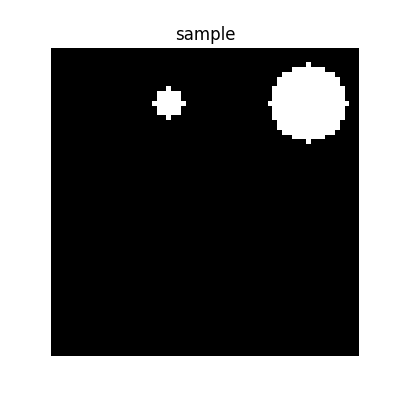

In [10]:
frames2gif()

In [11]:
import logging
import json
import os
from tensorflow.keras.callbacks import Callback
import numpy as np

class JSONMetricsLogger(Callback):
    def __init__(self, log_name="model"):
        super().__init__()
        os.makedirs("logs", exist_ok=True)
        self.log_path = os.path.join("logs", f"{log_name}_metrics.json")

        self.logger = logging.getLogger(f"{log_name}_logger")
        self.logger.setLevel(logging.INFO)
        self.logger.handlers.clear()

        handler = logging.FileHandler(self.log_path, mode="w")
        formatter = logging.Formatter('%(message)s')
        handler.setFormatter(formatter)
        self.logger.addHandler(handler)

    def on_epoch_end(self, epoch, logs=None):
        if logs:
            cleaned_logs = {
                k: float(v) if isinstance(v, (np.floating, float, int)) else str(v)
                for k, v in logs.items()
            }
            cleaned_logs['epoch'] = epoch + 1
            self.logger.info(json.dumps(cleaned_logs))


# ConvLstm with conv3d(3,3,3)

In [23]:
from tensorflow.keras import Sequential, layers, optimizers, losses

convlstm_model = Sequential([
    layers.Input(shape=(None, 64, 64, 1)),  # [B, T, H, W, C]

    layers.ConvLSTM2D(64, (5, 5), padding='same', return_sequences=True, activation='relu'),
    layers.BatchNormalization(),

    layers.ConvLSTM2D(64, (3, 3), padding='same', return_sequences=True, activation='relu'),
    layers.BatchNormalization(),

    layers.ConvLSTM2D(64, (1, 1), padding='same', return_sequences=True, activation='relu'),

    layers.Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')
], name="convlstm_model")


convlstm_model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.BinaryCrossentropy(),
    metrics=['binary_accuracy']
)


In [108]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
json_logger = JSONMetricsLogger(log_name="convlstm")

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
convlstm_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr, json_logger],
)

Epoch 1/20


2025-07-05 07:06:42.400805: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1021] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/convlstm_model/conv_lstm2d_14/while/convlstm_model/conv_lstm2d_14/while_grad/body/_555/input/_1530' -> 'gradient_tape/convlstm_model/conv_lstm2d_14/while/convlstm_model/conv_lstm2d_14/while_grad/body/_555/gradient_tape/convlstm_model/conv_lstm2d_14/while/gradients/AddN', 'Func/gradient_tape/convlstm_model/conv_lstm2d_13/while/convlstm_model/conv_lstm2d_13/while_grad/body/_750/input/_1649' -> 'gradient_tape/convlstm_model/conv_lstm2d_13/while/convlstm_model/conv_lstm2d_13/while_grad/body/_750/gradient_tape/convlstm_model/conv_lstm2d_13/while/gradients/AddN', 'Func/gradient_tape/convlstm_model/conv_lstm2d_12/while/convlstm_model/conv_lstm2d_12/while_grad/body/_945/input/_1765' -> 'gradient_tape/convlstm_model/conv_lstm2d_12/while/convlstm_model/conv_lstm2d_12/while_grad

360/360 [==============================] - 54s 142ms/step - loss: 0.0147 - binary_accuracy: 0.9949 - val_loss: 0.1651 - val_binary_accuracy: 0.9618 - lr: 0.0010
Epoch 2/20
360/360 [==============================] - 50s 138ms/step - loss: 4.5269e-04 - binary_accuracy: 0.9998 - val_loss: 5.1198e-04 - val_binary_accuracy: 0.9998 - lr: 0.0010
Epoch 3/20
360/360 [==============================] - 51s 141ms/step - loss: 3.9403e-04 - binary_accuracy: 0.9998 - val_loss: 3.8777e-04 - val_binary_accuracy: 0.9998 - lr: 0.0010
Epoch 4/20
360/360 [==============================] - 49s 137ms/step - loss: 3.7067e-04 - binary_accuracy: 0.9999 - val_loss: 3.9695e-04 - val_binary_accuracy: 0.9998 - lr: 0.0010
Epoch 5/20
360/360 [==============================] - 51s 141ms/step - loss: 3.5711e-04 - binary_accuracy: 0.9999 - val_loss: 3.7699e-04 - val_binary_accuracy: 0.9998 - lr: 0.0010
Epoch 6/20
360/360 [==============================] - 51s 141ms/step - loss: 3.4812e-04 - binary_accuracy: 0.9999 - val

## Prediction Example

In [24]:
def prediction_demo(pred_model=convlstm_model,example_idx = np.random.choice(len(val_dataset), size=1)[0]):
    # Select a random example from the validation dataset.
    example = val_dataset[example_idx]

    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    base_frames = frames
    original_frames = example[10:, ...]

    # Predict a new set of 10 frames.
    for _ in range(10):
        new_prediction = pred_model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
        frames = np.concatenate((frames, predicted_frame), axis=0)

    # Final predicted frames (last 10)
    new_frames = frames[10:, ...]

    # ✅ Create figure with 3 rows: base, original, predicted
    fig, axes = plt.subplots(3, 10, figsize=(20, 6))

    # Plot base (input) frames
    for idx, ax in enumerate(axes[0]):
        ax.imshow(np.squeeze(base_frames[idx]), cmap="gray")
        ax.set_title(f"Input Frame {idx + 1}")
        ax.axis("off")

    # Plot original (ground truth future) frames
    for idx, ax in enumerate(axes[1]):
        ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
        ax.set_title(f"True Frame {idx + 11}")
        ax.axis("off")

    # Plot predicted frames
    for idx, ax in enumerate(axes[2]):
        ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
        ax.set_title(f"Predicted {idx + 11}")
        ax.axis("off")

    print(f"We demonstrate the prediction on validation dataset {example_idx}")

    plt.tight_layout()
    plt.show()
    
    original_all_frames = np.concatenate([base_frames, original_frames], axis=0)
    frames2gif("pred_demo","oringal.gif",original_all_frames)
    
    predict_all_frames = np.concatenate([base_frames, new_frames], axis=0)
    frames2gif("pred_demo",f"predict_{pred_model.name}.gif",predict_all_frames)
    


1/1 [==============================] - 0s 51ms/step
We demonstrate the prediction on validation dataset 9


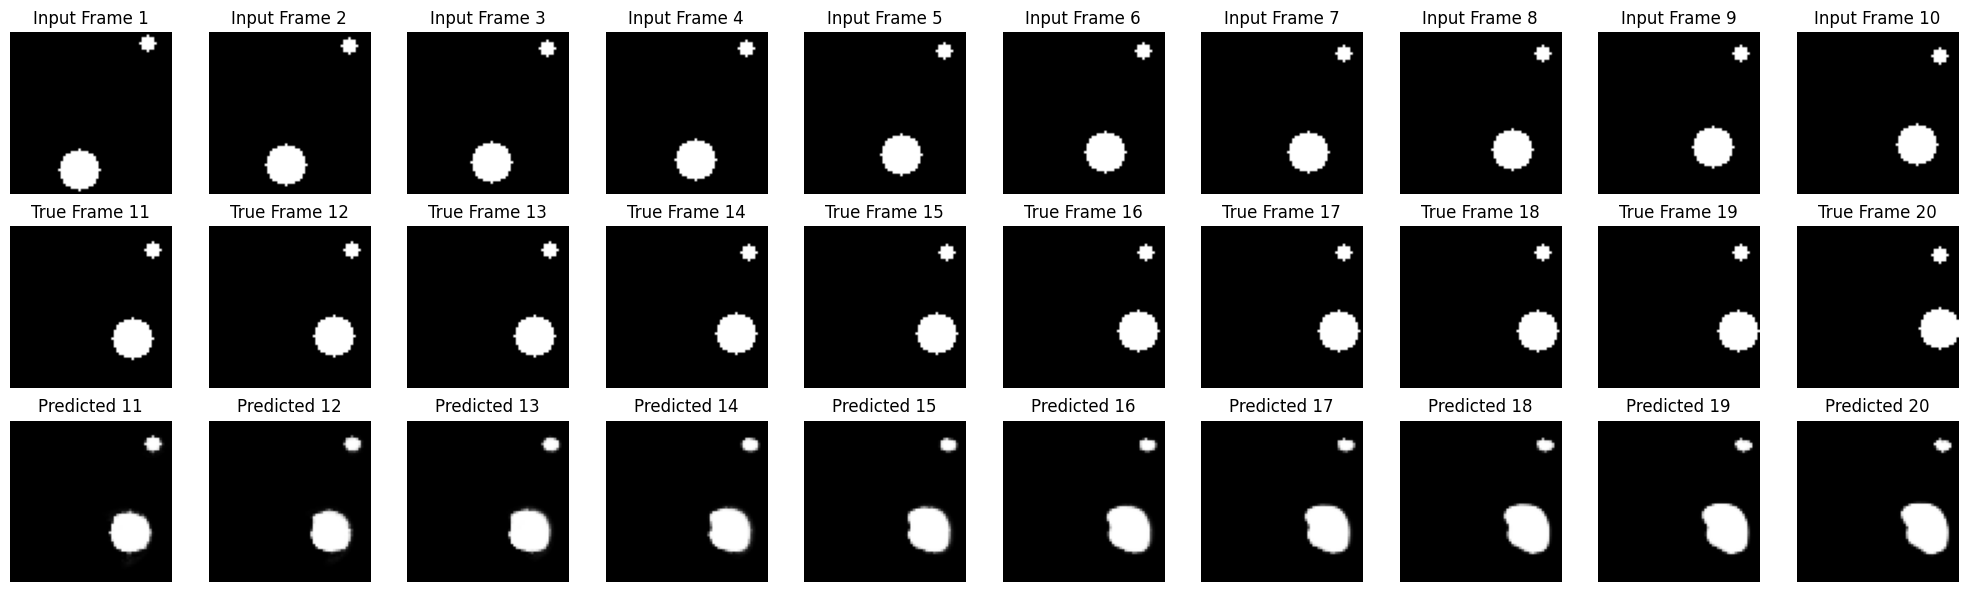

✅ Saved GIF: pred_demo/oringal.gif


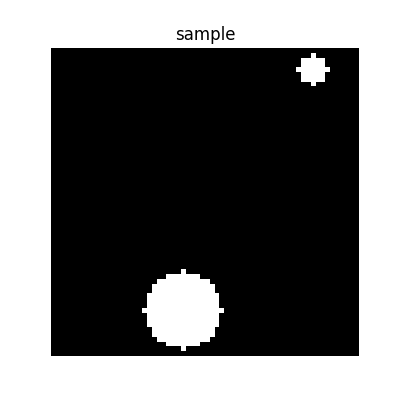

✅ Saved GIF: pred_demo/predict_convlstm_model.gif


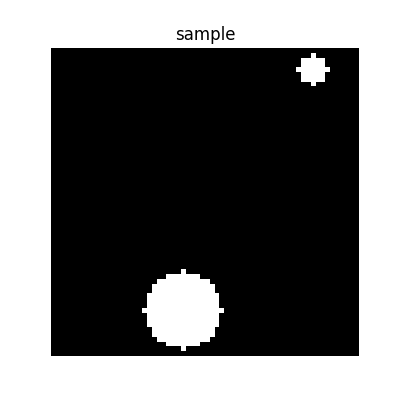

In [111]:
prediction_demo(pred_model=convlstm_model,example_idx=9 )

# ConvLstm with conv3d(1,1,1)

In [16]:
from tensorflow.keras import Sequential, layers, optimizers, losses

convlstm_model2 = Sequential([
    layers.Input(shape=(None, 64, 64, 1)),  # [B, T, H, W, C]

    layers.ConvLSTM2D(64, (5, 5), padding='same', return_sequences=True, activation='relu'),
    layers.BatchNormalization(),

    layers.ConvLSTM2D(64, (3, 3), padding='same', return_sequences=True, activation='relu'),
    layers.BatchNormalization(),

    layers.ConvLSTM2D(64, (1, 1), padding='same', return_sequences=True, activation='relu'),

    layers.Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')
], name="convlstm_model2")


convlstm_model2.compile(
    optimizer=optimizers.Adam(),
    loss=losses.BinaryCrossentropy(),
    metrics=['binary_accuracy']
)


2025-07-18 20:15:27.783888: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-18 20:15:27.850747: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-18 20:15:27.850776: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-18 20:15:27.852818: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-18 20:15:27.852844: I external/local_xla/xla/stream_executor

In [81]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
json_logger = JSONMetricsLogger(log_name="convlstm2")

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
convlstm_model2.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr, json_logger],
)

Epoch 1/20


2025-07-05 04:24:45.414164: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1021] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/sequential_2/conv_lstm2d_8/while/sequential_2/conv_lstm2d_8/while_grad/body/_555/input/_1530' -> 'gradient_tape/sequential_2/conv_lstm2d_8/while/sequential_2/conv_lstm2d_8/while_grad/body/_555/gradient_tape/sequential_2/conv_lstm2d_8/while/gradients/AddN', 'Func/gradient_tape/sequential_2/conv_lstm2d_7/while/sequential_2/conv_lstm2d_7/while_grad/body/_750/input/_1649' -> 'gradient_tape/sequential_2/conv_lstm2d_7/while/sequential_2/conv_lstm2d_7/while_grad/body/_750/gradient_tape/sequential_2/conv_lstm2d_7/while/gradients/AddN', 'Func/gradient_tape/sequential_2/conv_lstm2d_6/while/sequential_2/conv_lstm2d_6/while_grad/body/_945/input/_1765' -> 'gradient_tape/sequential_2/conv_lstm2d_6/while/sequential_2/conv_lstm2d_6/while_grad/body/_945/gradient_tape/sequential_2/conv

360/360 [==============================] - 56s 149ms/step - loss: 0.0133 - binary_accuracy: 0.9964 - val_loss: 0.1497 - val_binary_accuracy: 0.9618 - lr: 0.0010
Epoch 2/20
360/360 [==============================] - 54s 149ms/step - loss: 4.4809e-04 - binary_accuracy: 0.9998 - val_loss: 7.0367e-04 - val_binary_accuracy: 0.9998 - lr: 0.0010
Epoch 3/20
360/360 [==============================] - 52s 145ms/step - loss: 3.8945e-04 - binary_accuracy: 0.9998 - val_loss: 3.9982e-04 - val_binary_accuracy: 0.9998 - lr: 0.0010
Epoch 4/20
360/360 [==============================] - 53s 146ms/step - loss: 3.6466e-04 - binary_accuracy: 0.9999 - val_loss: 4.0395e-04 - val_binary_accuracy: 0.9998 - lr: 0.0010
Epoch 5/20
360/360 [==============================] - 53s 147ms/step - loss: 3.5345e-04 - binary_accuracy: 0.9999 - val_loss: 3.6387e-04 - val_binary_accuracy: 0.9999 - lr: 0.0010
Epoch 6/20
360/360 [==============================] - 53s 147ms/step - loss: 3.4338e-04 - binary_accuracy: 0.9999 - val

1/1 [==============================] - 0s 43ms/step
We demonstrate the prediction on validation dataset 9


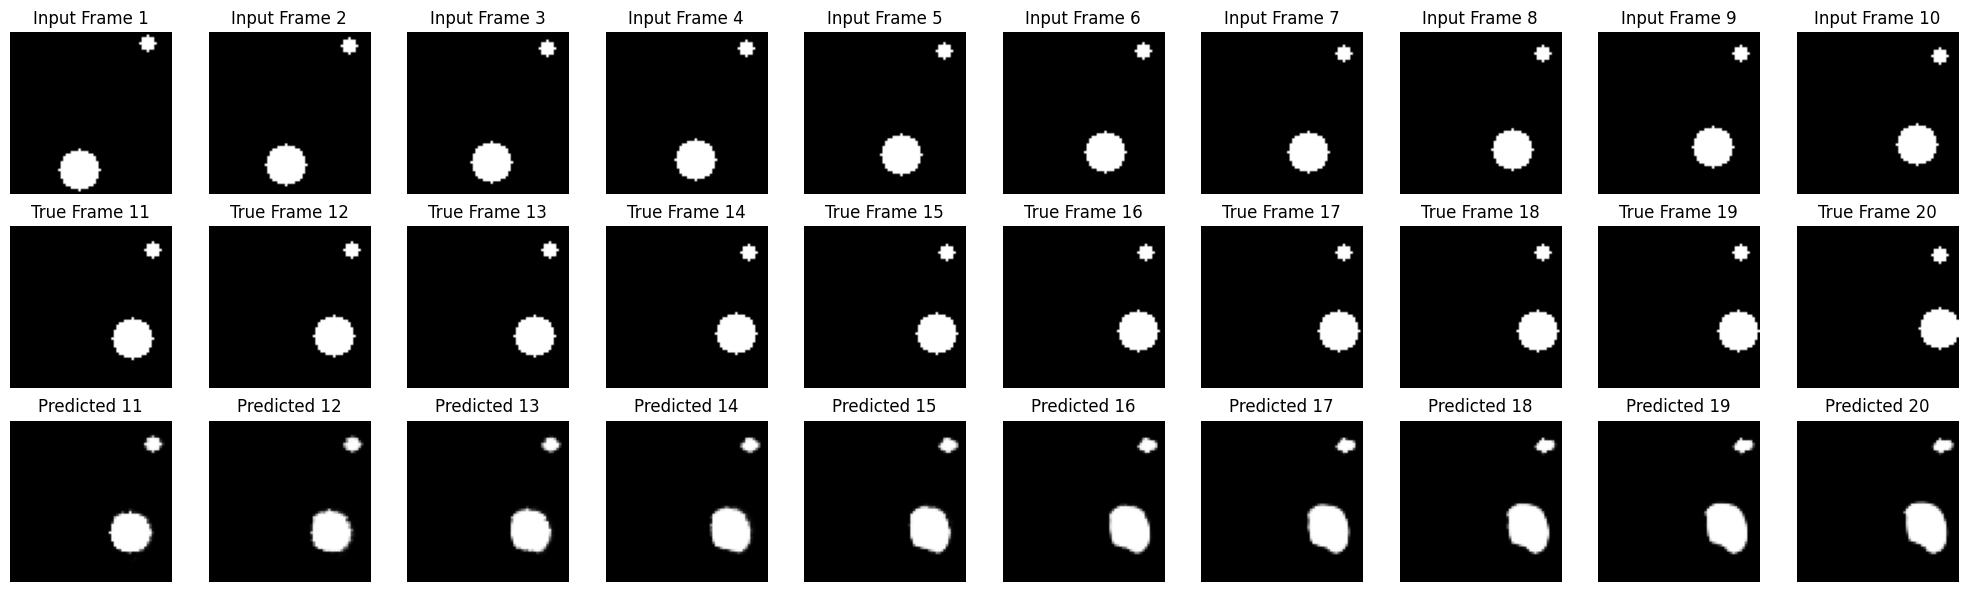

✅ Saved GIF: pred_demo/oringal.gif


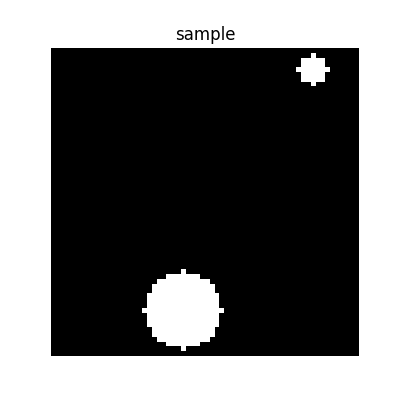

✅ Saved GIF: pred_demo/predict_Sequential.gif


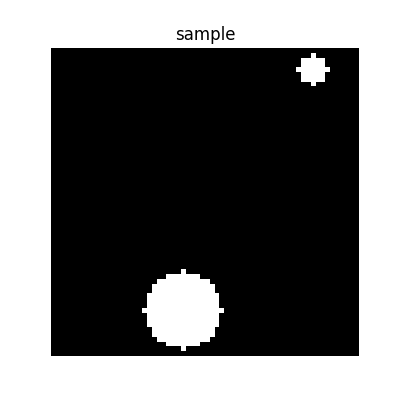

In [99]:
prediction_demo(pred_model=convlstm_model2,example_idx = 9)

# LTC

In [12]:
import sys
import os

# Step 1: Get parent directory
parent_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(parent_path)
# Step 2: Add it to sys.path
if parent_path not in sys.path:
    sys.path.insert(0, parent_path)


/workspace


In [13]:
from ncps_sz.ncps.tf import LTC
from ncps_sz.ncps.wirings import GridWiring


In [ ]:
from tensorflow.keras import Sequential, layers, optimizers, losses
from ncps_sz.ncps.tf import LTC
from ncps_sz.ncps.wirings import GridWiring



grid_wiring_model = Sequential([
    layers.Input(shape=(None, 64, 64, 1)),#(timestep,64,64,1)

    # Encoder (same filters as ConvLSTM)
    layers.TimeDistributed(layers.Conv2D(64, (5, 5), padding='same', activation='relu')),#(timestep, (64,64),64features)
    layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', activation='relu')),#(timestep, (64,64),64features)
    layers.TimeDistributed(layers.Conv2D(64, (1, 1), padding='same', activation='relu')),#(timestep, (64,64),64features)

     # Project to LTC input size
    layers.TimeDistributed(layers.Reshape((9, 9))), 

    # Temporal core: NCP with 64 output neurons (matching ConvLSTM filters)
    LTC(GridWiring(neuron_height=9, neuron_width=9), return_sequences=True),

    # Decoder: vector → frame
    layers.TimeDistributed(layers.Dense(64 * 64, activation='relu')),
    layers.TimeDistributed(layers.Reshape((64, 64, 1))),

    # Temporal frame stack → 3D conv to smooth spatiotemporal output
    layers.Reshape((-1, 64, 64, 1)),  # [B, T, H, W, 1]
    layers.Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')
])

grid_wiring_model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.BinaryCrossentropy(),
    metrics=['binary_accuracy']
)


ValueError: Exception encountered when calling layer 'reshape_4' (type Reshape).

total size of new array must be unchanged, input_shape = [64, 64, 64], output_shape = [9, 9]

Call arguments received by layer 'reshape_4' (type Reshape):
  • inputs=tf.Tensor(shape=(None, 64, 64, 64), dtype=float32)

# NCP

In [17]:
from tensorflow.keras import Sequential, layers, optimizers, losses
from ncps.tf import LTC
from ncps.wirings import AutoNCP

convncp_model = Sequential([
    layers.Input(shape=(None, 64, 64, 1)),

    # Encoder (same filters as ConvLSTM)
    layers.TimeDistributed(layers.Conv2D(64, (5, 5), padding='same', activation='relu')),
    layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', activation='relu')),
    layers.TimeDistributed(layers.Conv2D(64, (1, 1), padding='same', activation='relu')),

    # Flatten spatial dimensions
    layers.TimeDistributed(layers.Flatten()),
    layers.TimeDistributed(layers.Dense(64)),  # Project to LTC input size

    # Temporal core: NCP with 64 output neurons (matching ConvLSTM filters)
    LTC(AutoNCP(units=96, output_size=64), return_sequences=True),

    # Decoder: vector → frame
    layers.TimeDistributed(layers.Dense(64 * 64, activation='relu')),
    layers.TimeDistributed(layers.Reshape((64, 64, 1))),

    # Temporal frame stack → 3D conv to smooth spatiotemporal output
    layers.Reshape((-1, 64, 64, 1)),  # [B, T, H, W, 1]
    layers.Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')
])

convncp_model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.BinaryCrossentropy(),
    metrics=['binary_accuracy']
)


In [19]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
json_logger = JSONMetricsLogger(log_name="convncp")
epochs = 20
batch_size = 5

convncp_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr, json_logger],
)


Epoch 1/20


2025-07-18 20:17:00.812599: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90000
2025-07-18 20:17:01.982097: I external/local_xla/xla/service/service.cc:168] XLA service 0x7bcc10d27e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-18 20:17:01.982152: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-07-18 20:17:01.995521: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752869822.076973    3799 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


360/360 [==============================] - 39s 93ms/step - loss: 0.3556 - binary_accuracy: 0.9260 - val_loss: 0.1711 - val_binary_accuracy: 0.9640 - lr: 0.0010
Epoch 2/20
360/360 [==============================] - 30s 85ms/step - loss: 0.1348 - binary_accuracy: 0.9630 - val_loss: 0.1082 - val_binary_accuracy: 0.9640 - lr: 0.0010
Epoch 3/20
360/360 [==============================] - 31s 86ms/step - loss: 0.0977 - binary_accuracy: 0.9630 - val_loss: 0.0919 - val_binary_accuracy: 0.9640 - lr: 0.0010
Epoch 4/20
360/360 [==============================] - 32s 87ms/step - loss: 0.0844 - binary_accuracy: 0.9630 - val_loss: 0.0816 - val_binary_accuracy: 0.9640 - lr: 0.0010
Epoch 5/20
360/360 [==============================] - 27s 76ms/step - loss: 0.0753 - binary_accuracy: 0.9630 - val_loss: 0.0734 - val_binary_accuracy: 0.9640 - lr: 0.0010
Epoch 6/20
360/360 [==============================] - 28s 78ms/step - loss: 0.0689 - binary_accuracy: 0.9630 - val_loss: 0.0698 - val_binary_accuracy: 0.964

1/1 [==============================] - 0s 77ms/step
We demonstrate the prediction on validation dataset 9


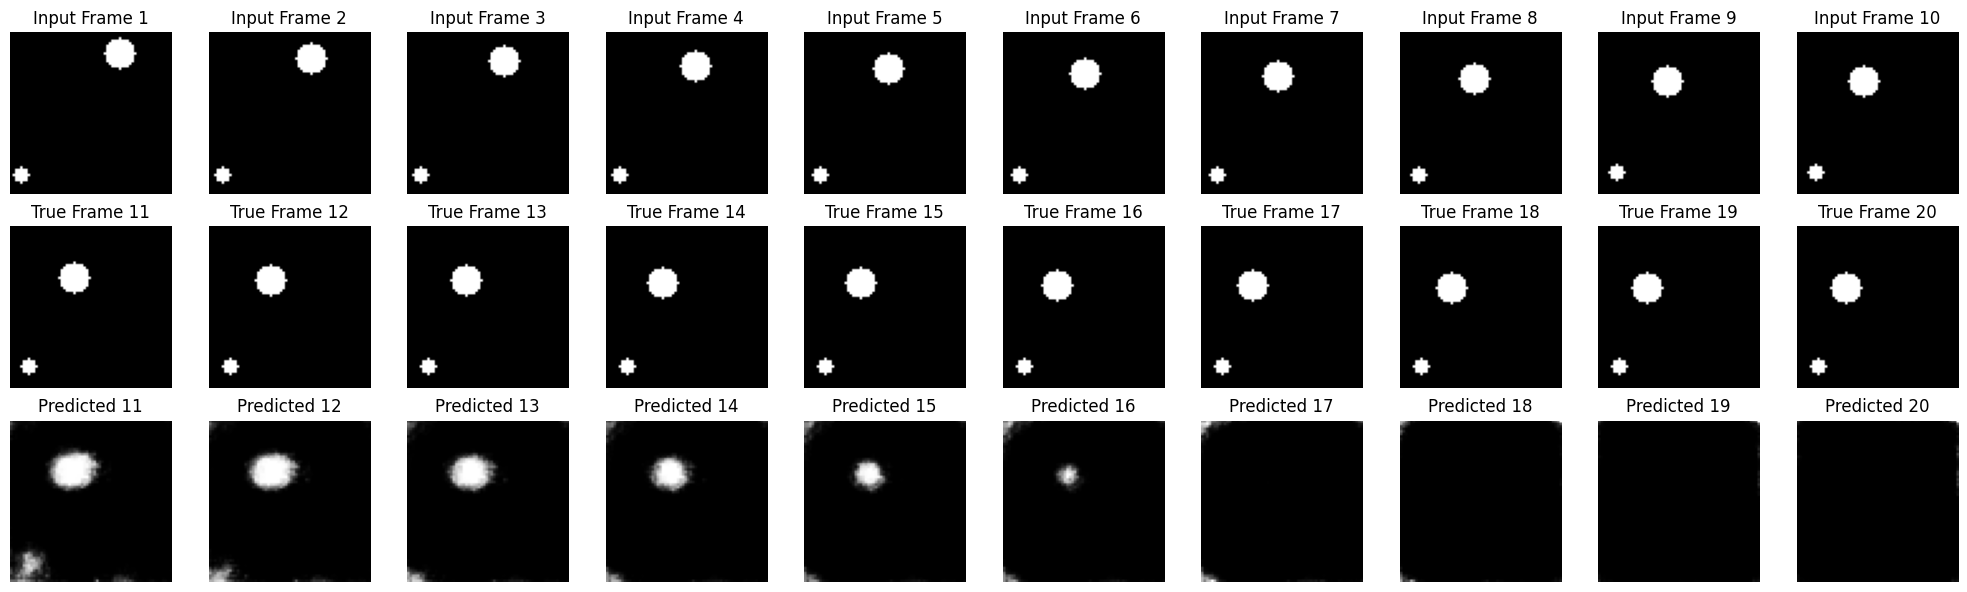

✅ Saved GIF: pred_demo/oringal.gif


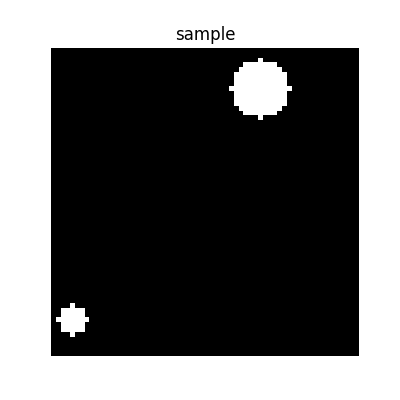

✅ Saved GIF: pred_demo/predict_sequential.gif


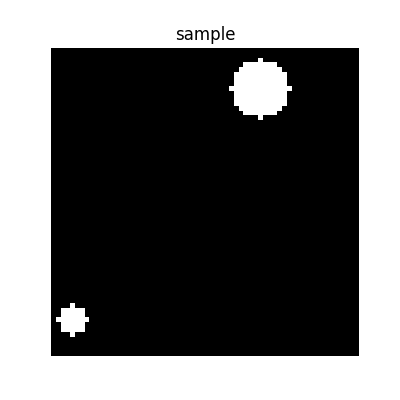

In [25]:
prediction_demo(pred_model=convncp_model,example_idx = 9)